In [511]:
import numpy as np
from torch_geometric.data import Data
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

key variables:
* n conv layers: [2, 4, 6, 8]
* n MLP layers: [1, 2, 3]
* use batch normalization: [True or False]
* conv dropout: [0.0, 0.3, 0.6]
* MLP dropout: [0.0, 0.3, 0.6]
* activation: [prelu, relu, swish, others?]
* aggregation: [max, mean, sum, others?]
* layer connectivity: [skipcat, skipsum, stack]
* optimizer: [SGD, Adam]
* learning rate: [0.1, 0.01, 0.001]

In [507]:
from dataclasses import dataclass
from typing import Union, Any

import torch
from torch_geometric.nn import (
    BatchNorm,
    Linear,
    GCNConv,
    SAGEConv,
    GATConv,
    GINEConv,
    global_add_pool,
    global_max_pool,
    global_mean_pool,
)
from torch.optim import SGD, Adam


@dataclass
class ModelConfig:
    n_input_features: int
    hidden_features: int
    n_labels: int
    n_conv_layers: int
    n_mlp_layers: int
    conv_layer: Union[str, Any]
    use_batch_norm: bool
    conv_dropout: float
    mlp_dropout: float
    conv_activation: Union[str, Any]
    mlp_activation: Union[str, Any]
    aggregation: str
    pool: str
    # conv_connection: str
    optimizer: Union[str, Any]
    learning_rate: float

    def __post_init__(self):
        if isinstance(self.conv_layer, str):
            self.conv_layer = {
                'gcnconv': GCNConv,
                'sageconv': SAGEConv,
                'gatconv': GATConv,
                'gineconv': GINEConv,
            }[self.conv_layer]
        if isinstance(self.pool, str):
            self.pool = {
                'add': global_add_pool,
                'max': global_max_pool,
                'mean': global_mean_pool,
            }[self.pool]
        if isinstance(self.optimizer, str):
            self.optimizer = {
                'sgd': SGD,
                'adam': Adam,
            }[self.optimizer]


class Model(torch.nn.Module):
    def __init__(self, config: ModelConfig) -> None:
        super().__init__()
        self.config = config
        modules = self.__dict__['_modules']
        for i in range(config.n_conv_layers):
            if i == 0:
                if config.use_batch_norm:
                    modules[f'batch_norm_{i}'] = BatchNorm(config.n_input_features).double()
                modules[f'conv_{i}'] = config.conv_layer(config.n_input_features, config.hidden_features).double()
            else:
                if config.use_batch_norm:
                    modules[f'batch_norm_{i}'] = BatchNorm(config.hidden_features).double()
                modules[f'conv_{i}'] = config.conv_layer(config.hidden_features, config.hidden_features).double()
            # if config.conv_activation == 'prelu':
            #     modules[f'conv_prelu_weights_{i}'] = torch.rand(config.hidden_features)
        for i in range(config.n_mlp_layers):
            if i == config.n_mlp_layers - 1:
                modules[f'mlp_{i}'] = Linear(config.hidden_features, config.n_labels).double()
            else:
                modules[f'mlp_{i}'] = Linear(config.hidden_features, config.hidden_features).double()
            # if config.mlp_activation == 'prelu':
            #     modules[f'mlp_prelu_weights_{i}'] = torch.rand(config.hidden_features)

        self.optimizer = config.optimizer(self.parameters(), lr=config.learning_rate)

    def forward(self, x, edge_index, batch):
        config = self.config
        modules = self.__dict__['_modules']
        x = x.double()

        for i in range(config.n_conv_layers):
            if config.use_batch_norm:
                x = modules[f'batch_norm_{i}'](x)
            x = modules[f'conv_{i}'](x, edge_index)
            if i != config.n_conv_layers - 1:
                if config.conv_activation == 'prelu':
                    x = getattr(x, config.conv_activation)(torch.tensor(1))
                else:
                    x = getattr(x, config.conv_activation)()

        x = config.pool(x, batch)

        for i in range(config.n_mlp_layers):
            x = modules[f'mlp_{i}'](x)
            if i != config.n_mlp_layers - 1:
                if config.mlp_activation == 'prelu':
                    x = getattr(x, config.mlp_activation)(torch.tensor(1))
                else:
                    x = getattr(x, config.mlp_activation)()

        return x

In [508]:
config = ModelConfig(
    n_input_features=9,
    hidden_features=32,
    n_labels=1,
    n_conv_layers=2,
    n_mlp_layers=2,
    conv_layer='gcnconv',
    use_batch_norm=True,
    conv_dropout=0.0,
    mlp_dropout=0.2,
    conv_activation='prelu',
    mlp_activation='relu',
    aggregation='sum',
    pool='add',
    optimizer='adam',
    learning_rate=0.01)
model = Model(config)

In [499]:
from random import sample

import matplotlib.pyplot as plt
import numpy as np

from rdkit import Chem, RDLogger
from rdkit.Chem.Descriptors import MolWt

import torch
from torch.nn import MSELoss
from torch.optim import Adam

from torch_geometric.data import Data
from torch_geometric.utils.smiles import from_smiles
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import GCNConv, Linear, global_add_pool, global_mean_pool

from sklearn.model_selection import train_test_split

RDLogger.DisableLog('rdApp.*')

## prepare data

In [111]:
class Normalizer():
    def __init__(self, data):
        self.mean = np.mean(data)
        self.stdev = np.std(data)

    def normalize(self, data):
        return (data - self.mean) / self.stdev

    def unnormalize(self, data):
        return (data * self.stdev) + self.mean

In [154]:
smiles = []
mws = []
with open('chembl.smi') as smi_fh:
    for line in smi_fh.readlines():
        smi = line.split()[0]
        if '.' not in smi:
            mol = Chem.MolFromSmiles(smi)
            if mol is not None:
                mw = MolWt(mol)
                if mw <= 600:
                    smiles.append(Chem.MolToSmiles(mol))
                    mws.append(mw)
                    # mws.append(1 if mw < 200 else 0)

smiles_mws = list(zip(smiles, mws))
smiles_mws = sample(smiles_mws, 1000)
smiles, mws = zip(*smiles_mws)
smiles = np.array(smiles)
mws = np.array(mws)
normalizer = Normalizer(mws)
mws = normalizer.normalize(mws)

In [222]:
datalist = []
for smi, mw in zip(smiles, mws):
    data = from_smiles(smi)
    data.y = mw
    datalist.append(data)

train_datalist, test_datalist = train_test_split(datalist, test_size=0.2)

train_dataloader = DataLoader(train_datalist, batch_size=16)
test_dataloader = DataLoader(test_datalist, batch_size=16)

In [280]:
esol = MoleculeNet('.', 'esol')
labels = np.array([graph.y.item() for graph in esol])
normalizer = Normalizer(labels)
labels = normalizer.normalize(labels)
norm_esol = []
for data, label in zip(esol, labels):
    norm_esol.append(Data(data.x, data.edge_index, y=label))

train_datalist, test_datalist = train_test_split(norm_esol, test_size=0.2)

train_dataloader = DataLoader(train_datalist, batch_size=16)
test_dataloader = DataLoader(test_datalist, batch_size=16)

## build model

In [295]:
class Model(torch.nn.Module):
    def __init__(self, num_input_features) -> None:
        super().__init__()
        self.conv_1 = GCNConv(num_input_features, 32, aggr='sum').double()
        self.conv_2 = GCNConv(32, 32).double()
        self.lin_1 = Linear(32, 32).double()
        self.lin_2 = Linear(32, 1).double()

    def forward(self, x, edge_index, batch):
        x = x.double()
        x = self.conv_1(x, edge_index)
        x = x.relu()
        x = self.conv_2(x, edge_index)
        x = global_add_pool(x, batch)
        # x = global_mean_pool(x, batch)
        x = self.lin_1(x)
        x = x.relu()
        x = self.lin_2(x)

        return x

(1 - abs(pearson_r)) + mse: 1.1075837792587455


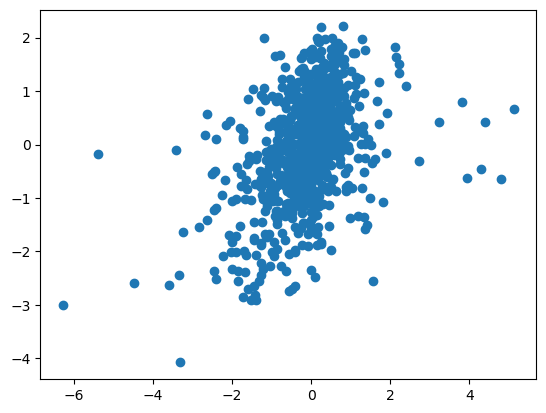

(1 - abs(pearson_r)) + mse: 0.2970853002099422


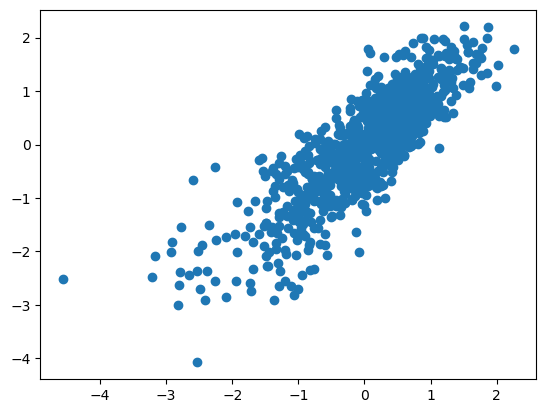

(1 - abs(pearson_r)) + mse: 0.2497535083858944


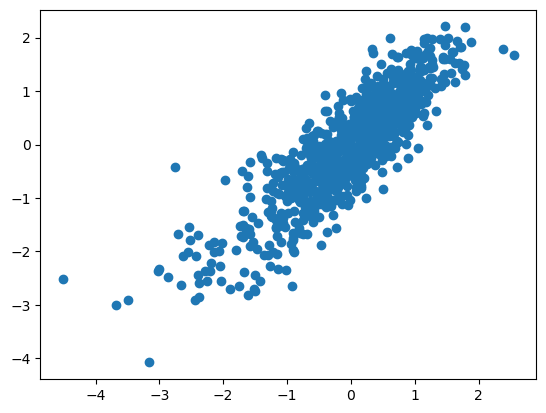

(1 - abs(pearson_r)) + mse: 0.2683904328480806


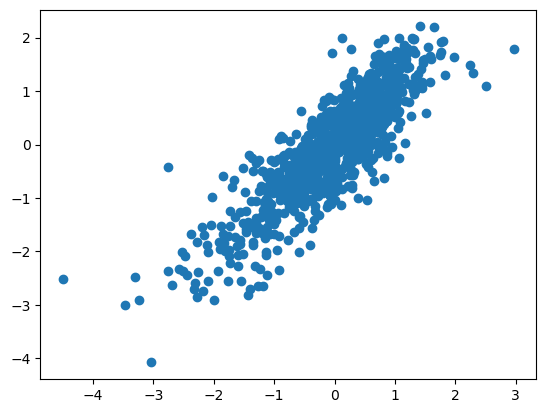

(1 - abs(pearson_r)) + mse: 0.22717946433423364


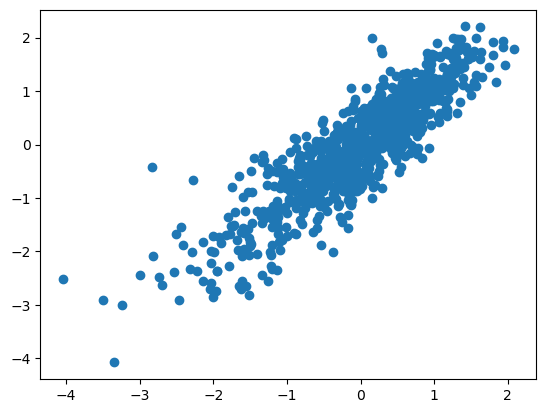

In [500]:
# model = Model(train_datalist[0].num_features)
# criterion = MSELoss()
# optimizer = Adam(model.parameters(), lr=0.01)

model = Model(config)
criterion = MSELoss()
optimizer = model.optimizer

model.train()
for epoch in range(100):
    pred_ys = []
    true_ys = []
    losses = []
    for batch in train_dataloader:
        optimizer.zero_grad()
        pred_y = model(batch.x, batch.edge_index, batch.batch).reshape(-1)
        true_y = batch.y.reshape(-1).double()
        custom_loss = 1 - torch.abs(torch.sum(pred_y * true_y) / (torch.sqrt(torch.sum(pred_y ** 2)) * torch.sqrt(torch.sum(true_y ** 2))))
        mse_loss = criterion(
            pred_y,
            true_y,
        )
        # loss = custom_loss
        loss = mse_loss
        # loss = custom_loss + mse_loss
        for y in pred_y:
            pred_ys.append(y.item())
        for y in batch.y:
            true_ys.append(y.item())
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    if epoch % 20 == 0:
        print('(1 - abs(pearson_r)) + mse:', np.mean(losses))
        plt.scatter(pred_ys, true_ys)
        plt.show()

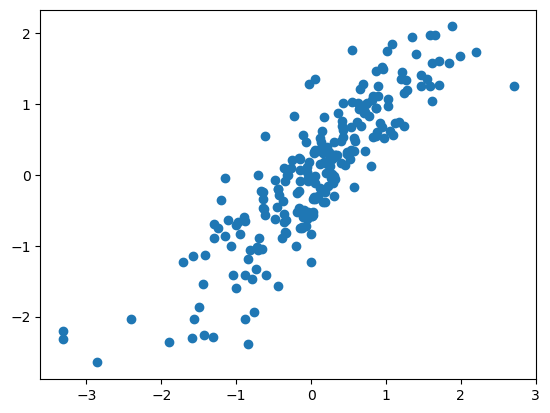

In [501]:
model.eval()
pred_y = []
true_y = []
for batch in test_dataloader:
    for y in model(batch.x, batch.edge_index, batch.batch).reshape(-1):
        pred_y.append(y.item())
    for y in batch.y:
        true_y.append(y.item())

plt.scatter(
    pred_y,
    true_y,
)
plt.show()